# k-means-finding-centers

In [79]:
from pylab import mpl
from collections import defaultdict
import re
import math
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np

In [80]:
mpl.rcParams['font.sans-serif']  = ['Arial Unicode MS']
mpl.rcParams['axes.unicode_minus'] = False

In [82]:
coordination_source = """
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

In [84]:
## Feacutre Extractor
city_location = {
    '香港': (114,17, 22.28)
}


test_string = "{name:'兰州‘, geoCoord:[103.73, 36.03]},"


pattern = re.compile(r"name:'(\w+)',\s+geoCoord:\[(\d+.\d+),\s(\d+.\d+)\]")

for line in coordination_source.split('\n'):
    
    city_info = pattern.findall(line)

    if not city_info: continue

    # following: we find the city info

    city, long, lat = city_info[0]

    long, lat = float(long), float(lat)

    city_location[city] = (long, lat)

city_location


{'香港': (114.17, 22.28),
 '贵阳': (106.71, 26.57),
 '武汉': (114.31, 30.52),
 '郑州': (113.65, 34.76),
 '济南': (117.0, 36.65),
 '南京': (118.78, 32.04),
 '合肥': (117.27, 31.86),
 '杭州': (120.19, 30.26),
 '南昌': (115.89, 28.68),
 '福州': (119.3, 26.08),
 '广州': (113.23, 23.16),
 '长沙': (113.0, 28.21),
 '海口': (110.35, 20.02),
 '沈阳': (123.38, 41.8),
 '长春': (125.35, 43.88),
 '哈尔滨': (126.63, 45.75),
 '太原': (112.53, 37.87),
 '西安': (108.95, 34.27),
 '台湾': (121.3, 25.03),
 '北京': (116.46, 39.92),
 '上海': (121.48, 31.22),
 '重庆': (106.54, 29.59),
 '天津': (117.2, 39.13),
 '呼和浩特': (111.65, 40.82),
 '南宁': (108.33, 22.84),
 '西藏': (91.11, 29.97),
 '银川': (106.27, 38.47),
 '乌鲁木齐': (87.68, 43.77),
 '澳门': (113.54, 22.19)}

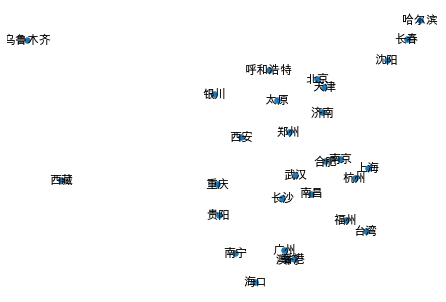

In [86]:
def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ------------
    origin: tuple of float
        (lat, long)
    destination: tuple of float
        (lat, long)
    
    Returns
    --------

    distance_in_km: float

    Examples
    ---------
    >>> origin = (48.1372, 11.5756) # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lon1, lat1 = origin
    lon2, lat2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
        math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    print(d)
    return d

%matplotlib inline

city_graph = nx.Graph()
city_graph.add_nodes_from(list(city_location.keys()))
nx.draw(city_graph, city_location, with_labels=True, node_size = 30)

In [87]:
k = 10

all_x = []
all_y = []

for _, location in city_location.items():
    x, y = location

    all_x.append(x)
    all_y.append(y)


def get_random_center(all_x, all_y):
    r_x = random.uniform(min(all_x), max(all_y))
    r_y = random.uniform(min(all_y), max(all_y))

    return r_x, r_y


get_random_center(all_x, all_y)


K = 5
centers = {'{}'.format(i+1):get_random_center(all_x, all_y) for i in range(K)}

closet_points = defaultdict(list)

for x, y in zip(all_x, all_y):
    closet_c, closet_dis = min([(k, geo_distance((x,y), centers[k])) for k in centers], key=lambda t: t[1])

    closet_points[closet_c].append([x,y])


def iterate_once(centers, closet_points, threshold = 5):
    have_changed = False

    for c in closet_points:
        former_center = centers[c]

        neighbors =closet_points[c]

        neighbors_center = np.mean(neighbors, axis = 0)

        if geo_distance(neighbors_center, former_center) > threshold:
            centers[c] = neighbors_center
            have_changed = True
        else:
            pass ## keep former center

    return centers, have_changed

6024.903717180583
4800.749804563061
5492.091174559206
6296.67583269914
4385.08141437176
5132.7391443241695
3908.2086108166
4669.66654504427
5403.884246143936
3505.4424376338307
5596.616039696108
4333.651102266097
5365.975700565605
5848.0193146718975
3823.964439274635
5347.414629397919
4079.2773311385254
5278.456261003324
5585.740528291824
3525.260215723278
5548.541683446628
4283.793479201793
5576.640368660368
5775.531683580727
3697.7218519147837
5905.509816258731
4637.529285693581
5772.388650986523
6146.264119661317
4088.869633501683
5785.764814697199
4518.324318257353
5632.598258579081
6029.135511516158
3978.531089916765
6113.992985038209
4846.89029285045
5929.512487154911
6358.312310695462
4308.677033922862
5824.956110432054
4565.174295740541
5540.377114578458
6079.586141983622
4066.490489339132
6258.867648317974
5001.910444277176
5918.480412979653
6515.8538290658735
4509.271548546496
5891.76829293588
4665.587757891776
5377.673918314606
6162.859003414151
4247.884395878514
5598.153458

In [88]:
def kmeans(Xs, k, threshold = 5):
    all_x = Xs[:, 0]
    all_y = Xs[:, 1]

    K = k

    centers = {'{}'.format(i+1): get_random_center(all_x, all_y) for i in range(K)}

    changed = True

    while changed:
        closet_points = defaultdict(list)

        for x, y, in zip(all_x, all_y):
            closet_c, closet_dis = min([(k, geo_distance((x, y), centers[k])) for k in centers], key=lambda t: t[1])
            closet_points[closet_c].append([x, y])

        centers, changed = iterate_once(centers, closet_points, threshold)
        print('iteration')
    return centers

kmeans(np.array(list(city_location.values())), k=5,threshold=5)

4047.7840816344747
4441.321371408573
5443.658004213405
3600.8835962285443
4526.169406715818
3177.0887592919594
3548.4066230436288
4587.645862589683
2839.741695697209
3761.5116015569743
3796.6556490155426
3995.5693870881973
5223.376007592858
3625.1543116825133
4532.048986976009
3671.247484291479
3758.5307047135516
5088.331461339246
3651.1669908309495
4527.510675232267
3958.6190498705832
3978.3323325145598
5363.757820253976
3995.5069682294743
4860.26845908716
4182.7877296181205
4312.615919238332
5606.819455197855
4066.797125209389
4967.095683286484
4046.133241479512
4190.197835770891
5471.018635600778
3922.9679822562207
4823.641663521513
4354.25436234336
4517.243161870404
5780.561123133351
4184.310728548342
5094.174825711305
3990.2419392707807
4223.206594201951
5416.007800405308
3758.7759264156234
4674.712694072756
4393.245919257891
4657.321264739624
5815.423416613318
4092.2910154359965
5015.626396593237
3921.9810255075718
4306.6215311843
5321.857207898831
3496.2946860902953
4422.1886496

{'1': array([116.73818182,  30.26636364]),
 '2': array([114.415,  40.806]),
 '3': (60.041774809271416, 27.92140107530695),
 '4': array([107.9975,  24.5775]),
 '5': (70.4360152889741, 20.053109628513614)}

{'能源站-1': (53.02037574117802, 37.838320581868985),
 '能源站-2': (67.42117240929971, 40.063271715187106),
 '能源站-3': (60.27397046342716, 23.35612187426721),
 '能源站-4': (49.856868579015874, 38.70937367520111),
 '能源站-5': (73.94012476018047, 43.79339793127472)}

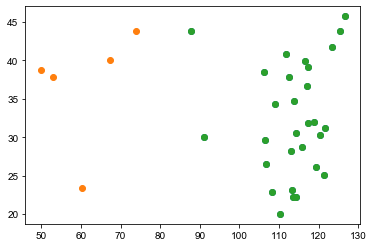

In [90]:
plt.scatter(all_x, all_y)

plt.scatter(*zip(*centers.values()))

for c, points in closet_points.items():
    plt.scatter(*zip(*points))


city_location_with_station = {
    '能源站-{}'.format(i): position for i, position in centers.items()
}
city_location_with_station

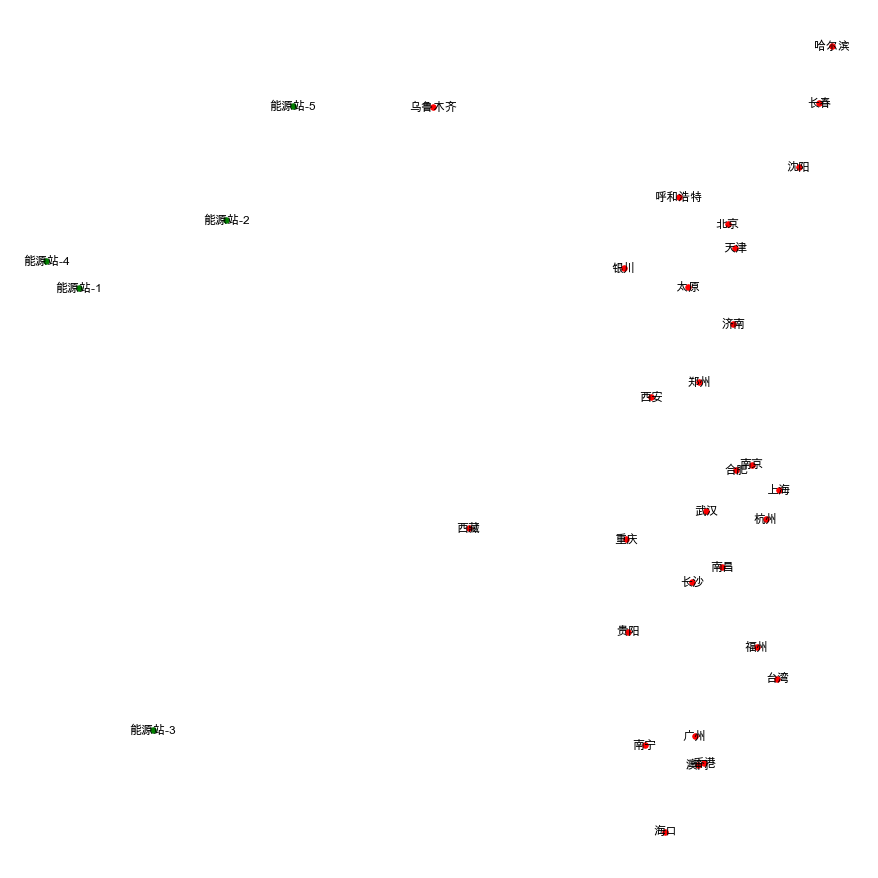

In [91]:
def draw_cities(citise, color = None):
    city_graph = nx.Graph()
    city_graph.add_nodes_from(list(citise.keys()))
    nx.draw(city_graph, citise, node_color = color, with_labels=True, node_size = 30)
%matplotlib inline


plt.figure(figsize = (12, 12))
draw_cities(city_location_with_station, color = 'green')
draw_cities(city_location, color = 'red')

# k-means-clustering-of-1-million-headlines

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


data = pd.read_csv("./data/abcnews-date-text.csv",error_bad_lines=False,usecols =["headline_text"])
data.head()

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers


In [20]:
data.to_csv('abcnews.csv', index=False, encoding='utf8')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1054983 entries, 0 to 1082167
Data columns (total 1 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   headline_text  1054983 non-null  object
dtypes: object(1)
memory usage: 16.1+ MB


## Deleting dupliate headlines(if any)

In [6]:
data[data['headline_text'].duplicated(keep=False)].sort_values('headline_text').head(8)

,headline_text
116304,10 killed in pakistan bus crash
57973,10 killed in pakistan bus crash
676588,110 with barry nicholls
673123,110 with barry nicholls
748887,110 with barry nicholls
912413,110 with barry nicholls
898238,110 with barry nicholls episode 15
827356,110 with barry nicholls episode 15


In [7]:
data = data.drop_duplicates('headline_text')

In [8]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = data['headline_text'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

In [10]:
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[5000:5100])

95709
['76000', '760000', '760k', '763', '769', '76ers', '76k', '76m', '76pc', '76yo', '76yos', '77', '770', '7700', '770000', '770k', '770m', '771m', '772m', '774', '774s', '775', '775m', '776m', '777', '777s', '779', '77b', '77k', '77kg', '77m', '77pc', '77yo', '78', '78000', '780k', '780m', '783', '783s', '785', '785m', '786', '787', '787s', '78b', '78er', '78ers', '78k', '78kg', '78kph', '78m', '78pc', '78th', '78yo', '79', '7900', '7917', '795', '795pc', '796m', '79b', '79kg', '79m', '79pc', '79th', '79yo', '7b', '7bn', '7cm', '7d', '7eleven', '7ho', '7k', '7kg', '7km', '7m', '7pc', '7pm', '7pmm', '7rar', '7s', '7th', '7wks', '7yo', '7yos', '7yr', '7yrs', '80', '800', '8000', '80000', '800000', '8003', '800b', '800k', '800kg', '800km', '800kms', '800m', '800pc']


In [11]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [12]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
print(len(word_features2))
print(word_features2[:50]) 

64035
["'a", "'i", "'s", "'t", 'aa', 'aaa', 'aaahhh', 'aac', 'aacc', 'aaco', 'aacta', 'aad', 'aadmi', 'aag', 'aagaard', 'aagard', 'aah', 'aalto', 'aam', 'aamer', 'aami', 'aamodt', 'aandahl', 'aant', 'aap', 'aapa', 'aapt', 'aar', 'aaradhna', 'aardman', 'aardvark', 'aargau', 'aaron', 'aaronpaul', 'aarwun', 'aat', 'ab', 'aba', 'abaaoud', 'ababa', 'aback', 'abadi', 'abadon', 'abal', 'abalon', 'abalonv', 'abama', 'abandon', 'abandond', 'abandong']


In [13]:
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)
words = vectorizer3.get_feature_names()

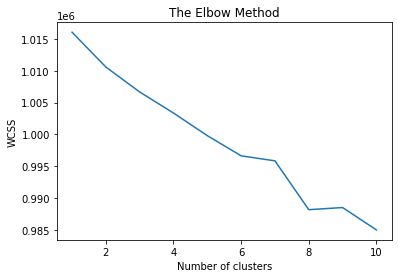

In [14]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [15]:
print(words[250:300])

['decid', 'decis', 'declar', 'defenc', 'defend', 'delay', 'deliv', 'demand', 'deni', 'despit', 'destroy', 'detent', 'develop', 'die', 'director', 'disabl', 'disast', 'discuss', 'diseas', 'dismiss', 'disput', 'doctor', 'dog', 'dollar', 'domest', 'donat', 'doubl', 'doubt', 'draw', 'dri', 'drink', 'drive', 'driver', 'drop', 'drought', 'drown', 'drug', 'drum', 'dump', 'dure', 'e', 'eagl', 'earli', 'eas', 'east', 'econom', 'economi', 'edg', 'educ', 'effort']


In [16]:
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X3)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : new, say, plan, council, win, govt, australia, report, court, charg, kill, fund, urg, warn, water, australian, face, nsw, open, death, chang, qld, year, crash, interview
1 : polic, investig, probe, offic, search, hunt, death, car, drug, arrest, miss, shoot, seek, charg, driver, crash, attack, say, murder, assault, suspect, fatal, raid, warn, station
2 : man, charg, jail, murder, court, polic, stab, die, face, miss, arrest, assault, accus, kill, attack, guilti, death, car, crash, child, shoot, sydney, sex, plead, search


In [17]:
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : polic, man, charg, interview, murder, court, assault, face, death, investig, drug, jail, arrest, car, stab, miss, attack, crash, probe, search, shoot, woman, offic, kill, child
1 : say, win, govt, australia, report, kill, court, warn, australian, fund, urg, nsw, open, death, crash, chang, wa, qld, claim, face, day, year, attack, hit, sydney
2 : plan, council, govt, consid, urg, fund, say, develop, chang, rate, reject, merger, park, seek, land, hous, meet, centr, group, mayor, green, resid, public, m, concern
3 : water, restrict, plan, suppli, irrig, council, govt, price, use, urg, murray, save, ban, pipelin, boost, resid, author, say, rise, drink, new, farmer, sa, qld, lake
4 : new, zealand, law, year, plan, open, council, polic, centr, home, hospit, deal, set, hope, appoint, australia, look, announc, chief, say, govt, minist, mayor, south, welcom


In [18]:
kmeans = KMeans(n_clusters = 6, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# We look at 6 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : man, say, win, charg, council, court, govt, australia, kill, report, face, fund, warn, urg, australian, water, crash, nsw, open, attack, interview, chang, qld, sydney, jail
1 : polic, investig, man, probe, search, offic, hunt, miss, arrest, car, charg, drug, shoot, attack, seek, assault, murder, crash, driver, say, fatal, suspect, raid, warn, bodi
2 : new, zealand, law, year, open, council, polic, home, deal, centr, hospit, set, hope, australia, appoint, look, chief, announc, say, south, govt, minist, mayor, servic, welcom
3 : plan, council, govt, water, new, say, develop, group, chang, unveil, park, reject, centr, urg, expans, green, health, public, resid, labor, reveal, opposit, power, govern, shire
4 : death, toll, polic, man, investig, inquest, charg, probe, coron, woman, rise, sentenc, babi, court, stab, road, custodi, jail, prompt, teen, face, spark, famili, driver, guilti
5 : hous, blaze, price, plan, public, white, man, polic, new, market, govt, parliament, sydney, destroy,

In [19]:
kmeans = KMeans(n_clusters = 8, n_init = 20, n_jobs = 1)
kmeans.fit(X3)
# Finally, we look at 8 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : man, charg, murder, court, face, jail, assault, stab, die, drug, guilti, death, child, sex, accus, attack, woman, crash, car, arrest, kill, miss, plead, sydney, teen
1 : interview, extend, nrl, afl, michael, john, speak, david, mark, smith, andrew, jame, peter, scott, polic, toni, william, cricket, minist, ceo, brown, jone, clark, murray, abc
2 : plan, council, fund, govt, water, boost, urg, consid, seek, develop, centr, chang, health, cut, reject, group, feder, school, rate, road, m, govern, budget, hous, land
3 : nation, countri, hour, podcast, wa, park, nsw, tas, vic, rural, sa, news, qld, nt, club, septemb, juli, march, friday, win, plan, liber, tri, pacif, candid
4 : polic, investig, probe, man, search, offic, hunt, miss, arrest, car, death, shoot, drug, seek, attack, assault, crash, charg, murder, driver, fatal, suspect, raid, warn, woman
5 : say, polic, need, govt, minist, mp, plan, union, expert, council, public, labor, group, australia, report, opposit, wont, govern, new, 

# Gradient

In [22]:
import random
def loss(k):
    return 3 * (k**2) + 7 * k - 10

# -b / 2a = -7 / 6

def partial(k):
    return 6 * k + 7

k = random.randint(-10, 10)

alpha = 1e-3 # 0.001

for i in range(1000):
    k = k + ( -1 ) * partial(k) * alpha
    print(k, loss(k))




-4.977 29.472587000000004
-4.954138 28.951483969132013
-4.931413172 28.436615414925313
-4.908824692968 27.92790674810115
-4.886371744810193 27.42528427176687
-4.8640535143413315 26.928675170739453
-4.841869193255284 26.438007500996733
-4.819817978095752 25.953210179254825
-4.797899070227178 25.474212972670216
-4.776111675805815 25.000946488665186
-4.75445500575098 24.533342164874796
-4.732928275716475 24.071332259214245
-4.711530706062176 23.61484984006499
-4.690261521825803 23.163828776578463
-4.669119952694848 22.71820372909547
-4.648105232978678 22.277910139680564
-4.627216601580806 21.842884222769428
-4.606453301971322 21.413062955928226
-4.585814582159494 20.988384070723512
-4.565299694666537 20.568786043701373
-4.544907896498538 20.15420808747453
-4.524638449119546 19.744590141915975
-4.504490618424829 19.339872865458087
-4.48446367471428 18.93999762649575
-4.464556892665994 18.54490649489236
-4.4447695513099985 18.154542233587467
-4.425100934002138 17.768848290304824
-4.40555032

# Gutting Problem

All the dynamic programing:
1. sub-problems
2. Overlapping sub-problems
3. parse solution

In [30]:
from collections import defaultdict
from functools import lru_cache
# least recent used

prices = [1, 5, 8, 9, 10, 17, 17, 20, 24, 30, 33]
complete_price = defaultdict(int)
for i, p in enumerate(prices): complete_price[i+1] = p

solution = {}

cache = {}
#<- if when n .... is huge. size(cache)
# keep most important information.


@lru_cache(maxsize=2**10)
def r(n):
    # a very classical dynamic programming problem
    # if n in cache: return cache[n]

    candidates = [(complete_price[n], (n, 0))] + \
                 [(r(i) + r(n-i), (i, n - i)) for i in range(1, n)]

    optimal_price, split = max(candidates)

    solution[n] = split

    # cache[n] = optimal_price

    return optimal_price


def parse_solution(n, cut_solution):
    left, right = cut_solution[n]

    if left == 0 or right == 0: return [left+right, ]
    else:
        return parse_solution(left, cut_solution) + parse_solution(right, cut_solution)


if __name__ == '__main__':
    print(r(19))
    print(parse_solution(19, solution))

55
[11, 6, 2]


In [27]:
from collections import defaultdict
from functools import wraps
from icecream import ic


original_price = [1, 5, 8, 9, 10, 17, 17, 20, 24, 30, 33]
price = defaultdict(int)
for i, p in enumerate(original_price):
    price[i+1] = p


def memo(func):
    cache = {}
    @wraps(func)
    def _wrap(n): ## ? *args, **kwargs
        if n in cache: result = cache[n]
        else:
            result = func(n)
            cache[n] = result
        return result
    return _wrap


@memo
def r(n):
    max_price, split_point = max(
        [(price[n], 0)] + [(r(i) + r(n-i), i) for i in range(1, n)], key=lambda x: x[0]
    )
    solution[n] = (split_point, n - split_point)
    
    return max_price


def not_cut(split): return split == 0

def parse_solution(target_length, revenue_solution):
    left, right = revenue_solution[target_length]
    
    if not_cut(left): return [right]

    return parse_solution(left, revenue_solution) + parse_solution(right, revenue_solution)


solution = {}
ic(r(50))
ic(parse_solution(20, solution))
ic(parse_solution(19, solution))
ic(parse_solution(27, solution))

ic| r(50): 150
ic| parse_solution(20, solution): [10, 10]
ic| parse_solution(19, solution): [2, 6, 11]
ic| parse_solution(27, solution): [6, 10, 11]


[6, 10, 11]

ic| x_star: 4.968, func(x_star): 414.78624
ic| x_star: 4.83664, func(x_star): 397.703344896
ic| x_star: 4.7079072, func(x_star): 381.29693243811846
ic| x_star: 4.5817490560000005, func(x_star): 365.540213913569
ic| x_star: 4.45811407488, func(x_star): 350.4074614425916
ic| x_star: 4.3369517933824, func(x_star): 335.87396596946496
ic| x_star: 4.218212757514752, func(x_star): 321.9159969170741
ic| x_star: 4.101848502364456, func(x_star): 308.5107634391579
ic| x_star: 3.987811532317167, func(x_star): 295.63637720696727
ic| x_star: 3.8760553016708235, func(x_star): 283.2718166695713
ic| x_star: 3.7665341956374068, func(x_star): 271.3968927294563
ic| x_star: 3.659203511724659, func(x_star): 259.99221577736984
ic| x_star: 3.5540194414901656, func(x_star): 249.03916403258597
ic| x_star: 3.4509390526603623, func(x_star): 238.5198531368956
ic| x_star: 3.349920271607155, func(x_star): 228.4171069526745
ic| x_star: 3.2509218661750117, func(x_star): 218.71442951734858
ic| x_star: 3.153903428851511

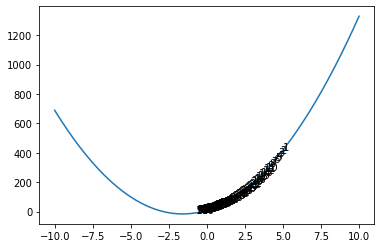

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random

from icecream import ic


def func(x):
    return 10 * x**2 + 32*x + 9


def gradient(x):
    return 20 *x + 32


x = np.linspace(-10, 10)


steps = []

x_star = random.choice(x)

alpha = 1e-3

for i in range(100):
    x_star = x_star + -1*gradient(x_star)*alpha
    steps.append(x_star)

    ic(x_star, func(x_star))

fig, ax = plt.subplots()
ax.plot(x, func(x))

for i, s in enumerate(steps):
    ax.annotate(str(i+1), (s, func(s)))

plt.show()

